# MRI Classification Using PyTorch
This notebook demonstrates how to load an MRI dataset, split it into training and validation sets, define a custom CNN model, and train the model using PyTorch.

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold
from torchvision.datasets import ImageFolder
import shutil
import json
import gc

## Data Preparation
Load the dataset and split it into training and validation sets, starting with first fold

In [2]:
with open('mean_std.json', 'r') as f:
    mean_std = json.load(f)

mean = mean_std['mean']
std = mean_std['std']

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Load data for fold 0
k_folds = 5
base_dir = 'dataset_kfold'
fold = 0
train_dir = os.path.join(base_dir, f'fold_{fold}', 'train')
val_dir = os.path.join(base_dir, f'fold_{fold}', 'val')
fold += 1

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

## Define the Model

In [3]:
# Define the ResNet model
class SimpleResNet(nn.Module):
    def __init__(self, num_classes):
        super(SimpleResNet, self).__init__()
        self.model = models.resnet50()
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

# Instantiate the model
num_classes = len(train_dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleResNet(num_classes=num_classes).to(device)

In [4]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        if batch_idx % 10 == 9:  # print every 10 batches
            print(f'Epoch {epoch}, Batch {batch_idx + 1}, Loss: {running_loss / 10:.4f}')
            running_loss = 0.0
    accuracy = 100. * correct / total
    return running_loss / len(train_loader), accuracy

# Define the validation function
def validate(model, device, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    val_loss /= len(val_loader)
    accuracy = 100. * correct / total
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%')
    return val_loss, accuracy

## Start training the model

In [6]:
# Training and validation loop with early stopping
num_epochs = 10
patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, device, train_loader, criterion, optimizer, epoch)
    val_loss, val_acc = validate(model, device, val_loader, criterion)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f'Epoch {epoch+1}/{num_epochs} - '
          f'Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f} - '
          f'Val loss: {val_loss:.4f}, Val accuracy: {val_acc:.4f}')
    
    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the best model if necessary
        # torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1

    if epochs_no_improve == patience:
        print('Early stopping!')
        break

Epoch 0, Batch 10, Loss: 1.7661
Validation Loss: 1.8322, Accuracy: 16.67%
Epoch 1/10 - Train loss: 0.1748, Train accuracy: 42.7083 - Val loss: 1.8322, Val accuracy: 16.6667
Epoch 1, Batch 10, Loss: 1.0141
Validation Loss: 5.4686, Accuracy: 36.46%
Epoch 2/10 - Train loss: 0.1745, Train accuracy: 58.5938 - Val loss: 5.4686, Val accuracy: 36.4583
Epoch 2, Batch 10, Loss: 0.9049
Validation Loss: 1.4858, Accuracy: 40.62%
Epoch 3/10 - Train loss: 0.1689, Train accuracy: 70.5729 - Val loss: 1.4858, Val accuracy: 40.6250
Epoch 3, Batch 10, Loss: 0.9637
Validation Loss: 0.9221, Accuracy: 65.62%
Epoch 4/10 - Train loss: 0.1271, Train accuracy: 62.5000 - Val loss: 0.9221, Val accuracy: 65.6250
Epoch 4, Batch 10, Loss: 0.6326
Validation Loss: 0.6463, Accuracy: 73.96%
Epoch 5/10 - Train loss: 0.0908, Train accuracy: 74.2188 - Val loss: 0.6463, Val accuracy: 73.9583
Epoch 5, Batch 10, Loss: 0.5051
Validation Loss: 0.9278, Accuracy: 68.75%
Epoch 6/10 - Train loss: 0.0820, Train accuracy: 78.1250 - Va

## Visualize

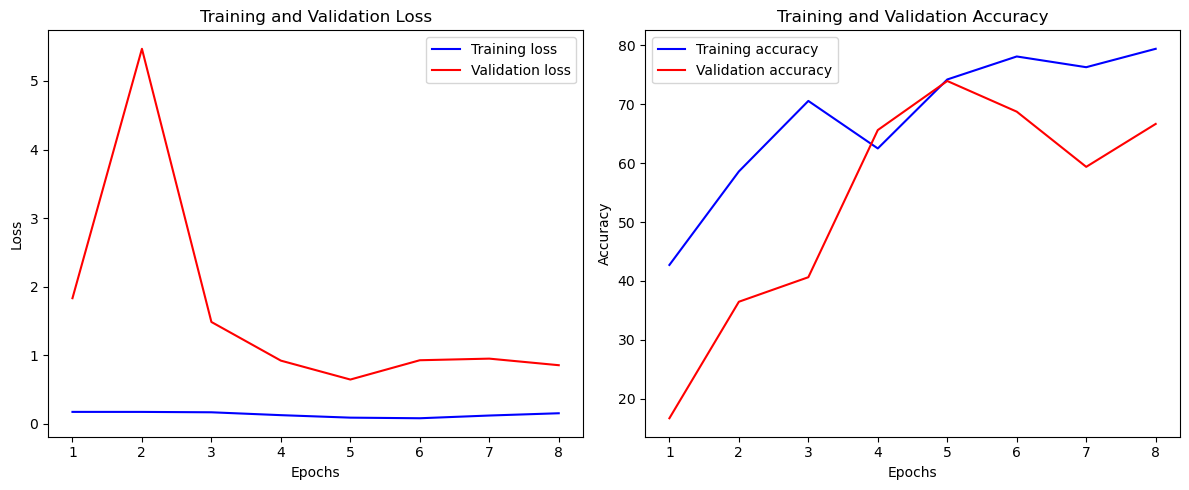

In [7]:
# Plotting the results
actual_epochs = range(1, epoch + 2)  # `epoch` is zero-based, so add 1 for one-based index and another 1 for inclusive range

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(actual_epochs, train_losses, 'b', label='Training loss')
plt.plot(actual_epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(actual_epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(actual_epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Remaining k-fold

In [8]:

fold_results = []

# Loop over each fold
for f in range(1, k_folds):
    print(f'Fold {f + 1}/{k_folds}')

    # Load data for fold
    train_dir = os.path.join(base_dir, f'fold_{f}', 'train')
    val_dir = os.path.join(base_dir, f'fold_{f}', 'val')

    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
    val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=50, shuffle=False, num_workers=4)

    # # Set device and model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleResNet(num_classes=num_classes).to(device)

    # Optimizer and criterion
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
    criterion = nn.CrossEntropyLoss()

    # Early stopping parameters
    num_epochs = 10
    patience = 3
    best_val_loss = float('inf')
    epochs_no_improve = 0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Training loop with early stopping
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, device, train_loader, criterion, optimizer, epoch)
        val_loss, val_acc = validate(model, device, val_loader, criterion)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs} - '
              f'Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f} - '
              f'Val loss: {val_loss:.4f}, Val accuracy: {val_acc:.4f}')

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            # Save the best model if necessary
            # torch.save(model.state_dict(), f'best_model_fold_{fold}.pth')
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print('Early stopping!')
            break

    # Free CUDA memory after training
    torch.cuda.empty_cache()
    gc.collect()

    # Store fold results
    fold_results.append({
        'fold': f,
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'best_val_loss': best_val_loss
    })


Fold 2/5
Validation Loss: 1.9915, Accuracy: 16.67%
Epoch 1/10 - Train loss: 1.7341, Train accuracy: 43.7500 - Val loss: 1.9915, Val accuracy: 16.6667
Validation Loss: 2.7336, Accuracy: 28.12%
Epoch 2/10 - Train loss: 0.9131, Train accuracy: 63.8021 - Val loss: 2.7336, Val accuracy: 28.1250
Validation Loss: 8.5984, Accuracy: 15.62%
Epoch 3/10 - Train loss: 0.7658, Train accuracy: 68.2292 - Val loss: 8.5984, Val accuracy: 15.6250
Validation Loss: 1.3056, Accuracy: 59.38%
Epoch 4/10 - Train loss: 0.7082, Train accuracy: 77.0833 - Val loss: 1.3056, Val accuracy: 59.3750
Validation Loss: 1.4456, Accuracy: 52.08%
Epoch 5/10 - Train loss: 0.5690, Train accuracy: 77.3438 - Val loss: 1.4456, Val accuracy: 52.0833
Validation Loss: 0.8823, Accuracy: 65.62%
Epoch 6/10 - Train loss: 0.5271, Train accuracy: 79.9479 - Val loss: 0.8823, Val accuracy: 65.6250
Validation Loss: 1.1499, Accuracy: 54.17%
Epoch 7/10 - Train loss: 0.5463, Train accuracy: 81.7708 - Val loss: 1.1499, Val accuracy: 54.1667
Vali

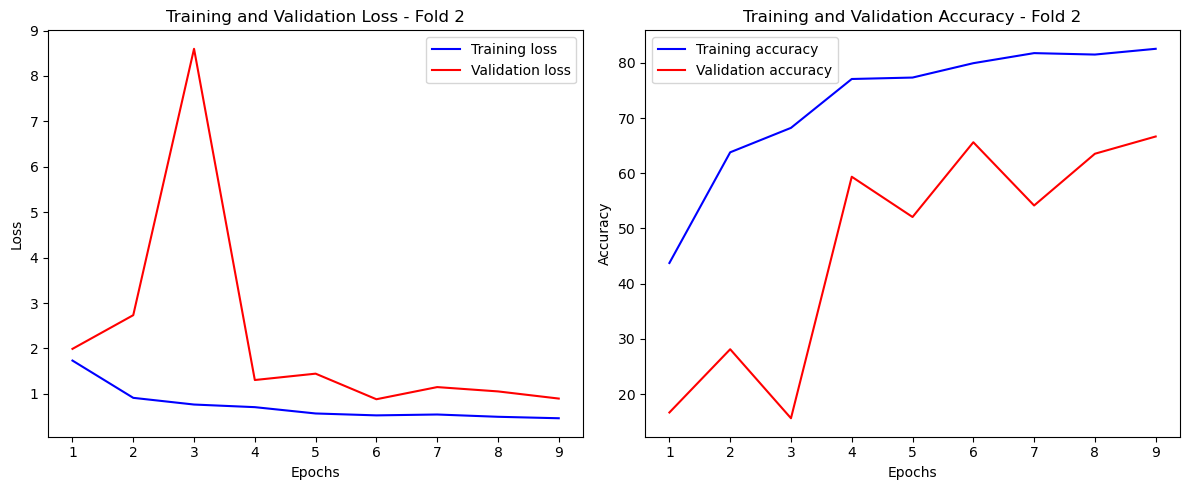

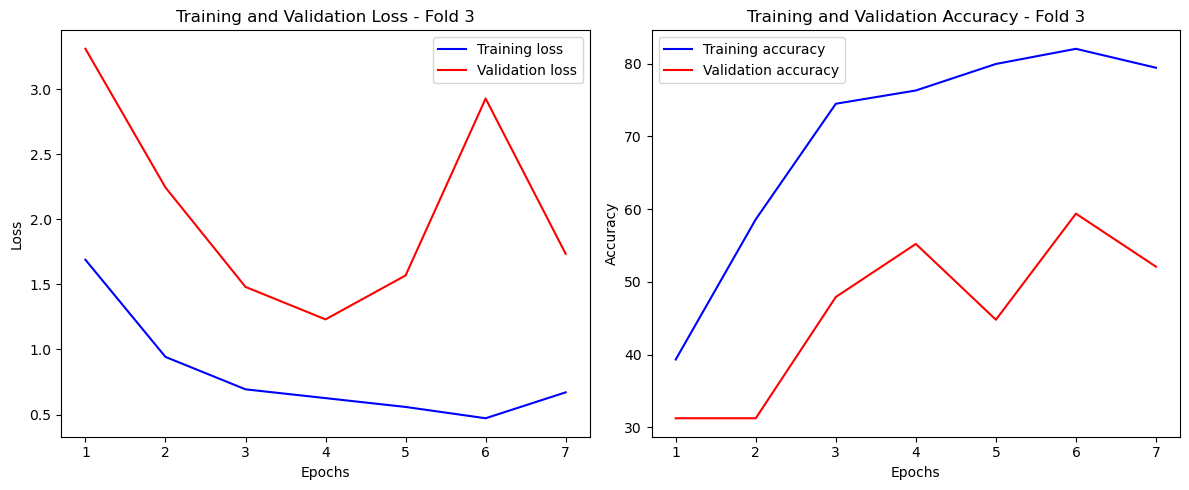

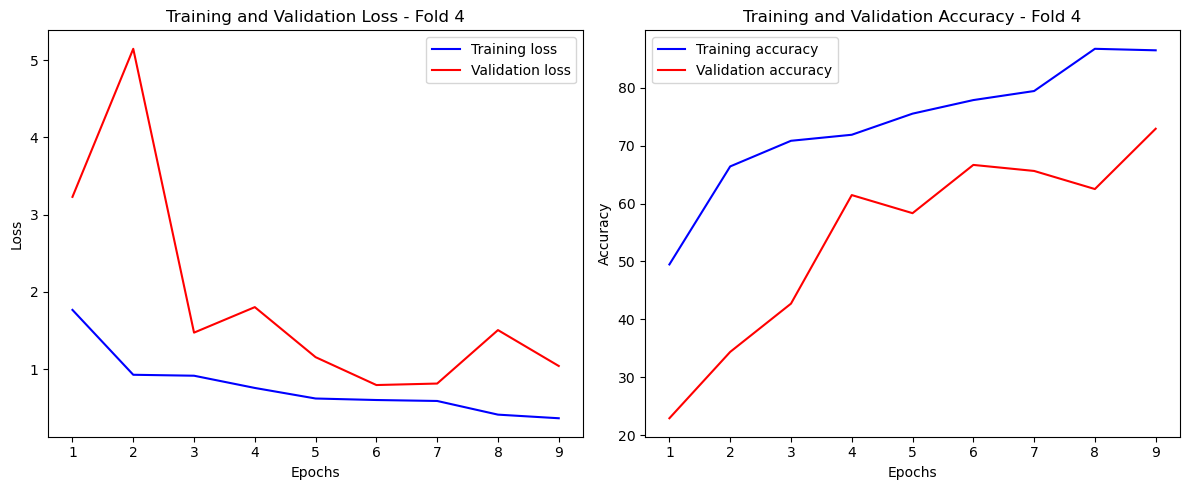

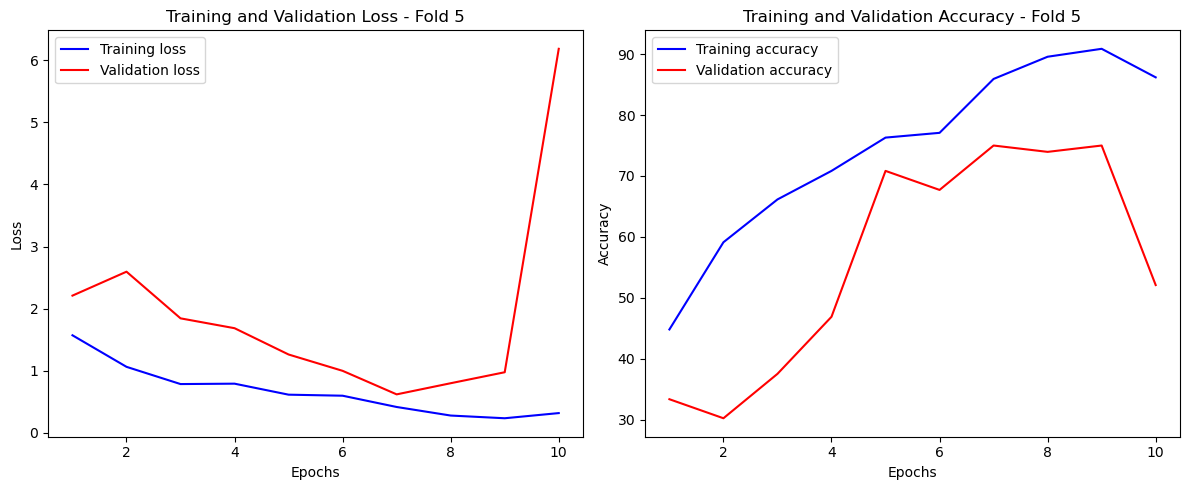

In [9]:
# Plotting results for each fold
for fold_result in fold_results:
    actual_epochs = range(1, len(fold_result['train_losses']) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(actual_epochs, fold_result['train_losses'], 'b', label='Training loss')
    plt.plot(actual_epochs, fold_result['val_losses'], 'r', label='Validation loss')
    plt.title(f'Training and Validation Loss - Fold {fold_result["fold"] + 1}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(actual_epochs, fold_result['train_accuracies'], 'b', label='Training accuracy')
    plt.plot(actual_epochs, fold_result['val_accuracies'], 'r', label='Validation accuracy')
    plt.title(f'Training and Validation Accuracy - Fold {fold_result["fold"] + 1}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Test

In [10]:
# def imshow(inp, title=None):
#     """Imshow for Tensor."""
#     inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
#     inp = np.clip(inp, 0, 1)
#     plt.imshow(inp)
#     if title is not None:
#         plt.title(title)
#     plt.pause(0.001)  # Pause a bit so that plots are updated

# # Ensure Matplotlib inline backend is set
# %matplotlib inline

# # Get one batch of validation data
# inputs, classes = next(iter(val_loader))

# inputs = inputs.to(device)
# classes = classes.to(device)
# # Load the entire model

# #Instantiate the model architecture
# model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# # Replace the final fully connected layer with the number of classes in your dataset
# num_features = model.fc.in_features
# model.fc = nn.Linear(num_features, num_classes)

# # Load the model state dictionary
# model.load_state_dict(torch.load('models/transfer_resnet_best.pth'))

# model = model.to(device)
# # Move the model to the appropriate device
# # Make predictions
# model.eval()
# with torch.no_grad():
#     outputs = model(inputs)
#     _, preds = torch.max(outputs, 1)

# # Move the inputs and classes to CPU for visualization
# inputs = inputs.cpu()
# classes = classes.cpu()
# preds = preds.cpu()

# # Class names
# class_names = train_dataset.classes

# # Randomly choose one data point to visualize
# index = random.randint(0, len(inputs) - 1)  # Select a random index from the batch
# input_image = inputs[index]
# predicted_label = class_names[preds[index]]
# actual_label = class_names[classes[index]]

# # Plot the image along with its predicted and actual labels
# plt.figure(figsize=(5, 5))
# imshow(input_image, title=f"Pred: {predicted_label}\nActual: {actual_label}")
# plt.show()
